In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [11]:
data = pd.read_csv('dataset_reformate2.csv')

data

,pays,date,nombre_total,entree_mensuelle
0,Albania,2014-02-01,1333,16.0
1,Germany,2014-02-01,306716,445.0
2,Andorra,2014-02-01,23,0.0
3,Austria,2014-02-01,41225,-37.0
4,Belarus,2014-02-01,1143,39.0
...,...,...,...,...
25795,Total Oceania,2024-10-01,4010,37.0
25796,Stateless,2024-10-01,1254,985.0
25797,Stateless,2024-10-01,272,-982.0
25798,Unknown,2024-10-01,1089,2.0


In [12]:
pays = 'Serbia'

data['date'] = pd.to_datetime(data['date'])  # Conversion en datetime
germany_data = data[data['pays'] == pays].sort_values(by='date')
germany_data

,pays,date,nombre_total,entree_mensuelle
40,Serbia,2014-02-01,77531,-1096.0
240,Serbia,2014-03-01,76385,-1146.0
440,Serbia,2014-04-01,75390,-995.0
640,Serbia,2014-05-01,74141,-1249.0
840,Serbia,2014-06-01,73103,-1038.0
...,...,...,...,...
24840,Serbia,2024-06-01,56562,-128.0
25040,Serbia,2024-07-01,56488,-74.0
25240,Serbia,2024-08-01,56412,-76.0
25440,Serbia,2024-09-01,56262,-150.0


In [13]:
# Paramètres de séquences temporelles
sequence_length = 12*3  # Utiliser les 12 derniers mois pour prédire le suivant

# Extraire la variable cible
values = germany_data['entree_mensuelle'].values.reshape(-1, 1)

# Normaliser les données
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_values = scaler.fit_transform(values)

# Créer les séquences temporelles
X, y = [], []
for i in range(len(normalized_values) - sequence_length):
    X.append(normalized_values[i:i + sequence_length])
    y.append(normalized_values[i + sequence_length])

X, y = np.array(X), np.array(y)

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Formes des ensembles
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((65, 36, 1), (28, 36, 1), (65, 1), (28, 1))

In [14]:
# Définir le modèle LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compiler le modèle
model.compile(optimizer='adam', loss='mean_squared_error')

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.2, verbose=1)

# Résultat de l'entraînement
history.history

Epoch 1/200


/Users/cyriltelley/Desktop/MSE/TSM-AnSeqDa/Project/ImmigrationProject_Python/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.5177 - val_loss: 0.4141
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4065 - val_loss: 0.3125
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3029 - val_loss: 0.2145
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2056 - val_loss: 0.1208
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1131 - val_loss: 0.0379
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0272 - val_loss: 0.0032
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0098 - val_loss: 0.0380
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0293 - val_loss: 0.0074
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0047 - val_loss: 0.0077
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0086 - val_loss: 0.0064
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0067 - val_loss: 0.0026
E

{'loss': [0.5027430057525635,
  0.39311808347702026,
  0.29178205132484436,
  0.19403372704982758,
  0.10126206278800964,
  0.022870127111673355,
  0.01345846988260746,
  0.026290349662303925,
  0.002766868332400918,
  0.005844688042998314,
  0.009422417730093002,
  0.006453786510974169,
  0.002556841354817152,
  0.0024828161112964153,
  0.0033114717807620764,
  0.0025980151258409023,
  0.0018964188639074564,
  0.0020262994803488255,
  0.0021164934150874615,
  0.0020053337793797255,
  0.0018748071743175387,
  0.001901519251987338,
  0.0020188153721392155,
  0.00196075439453125,
  0.00186449836473912,
  0.0019220231333747506,
  0.001959252869710326,
  0.0019399655284360051,
  0.001956394175067544,
  0.0018892913358286023,
  0.0018804532010108232,
  0.001888331607915461,
  0.001896534115076065,
  0.0018999718595296144,
  0.0019057958852499723,
  0.0019379773875698447,
  0.0019066453678533435,
  0.0019521835492923856,
  0.0019131861627101898,
  0.0018885512836277485,
  0.00188318197615444

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


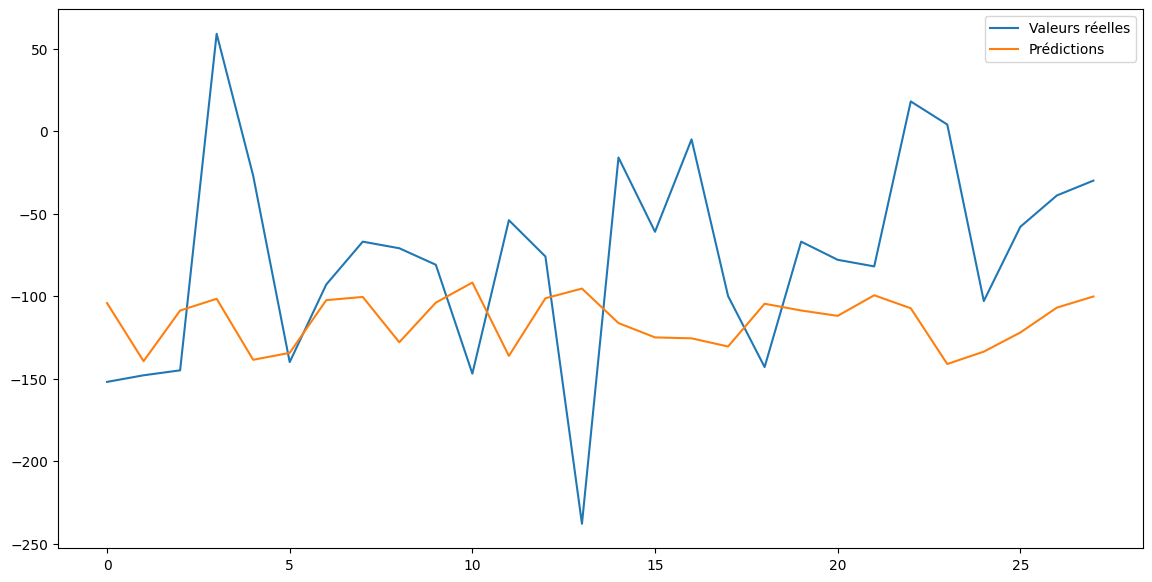

5836.525690766646

In [15]:
# Prédire les données de test
predicted_values = model.predict(X_test)

# Inverser la normalisation
predicted_values = scaler.inverse_transform(predicted_values)
y_test = scaler.inverse_transform(y_test)

# Visualiser les résultats
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valeurs réelles')
plt.plot(predicted_values, label='Prédictions')
plt.legend()
plt.show()

# Calculer l'erreur quadratique moyenne
mse = np.mean(np.square(y_test - predicted_values))
mse

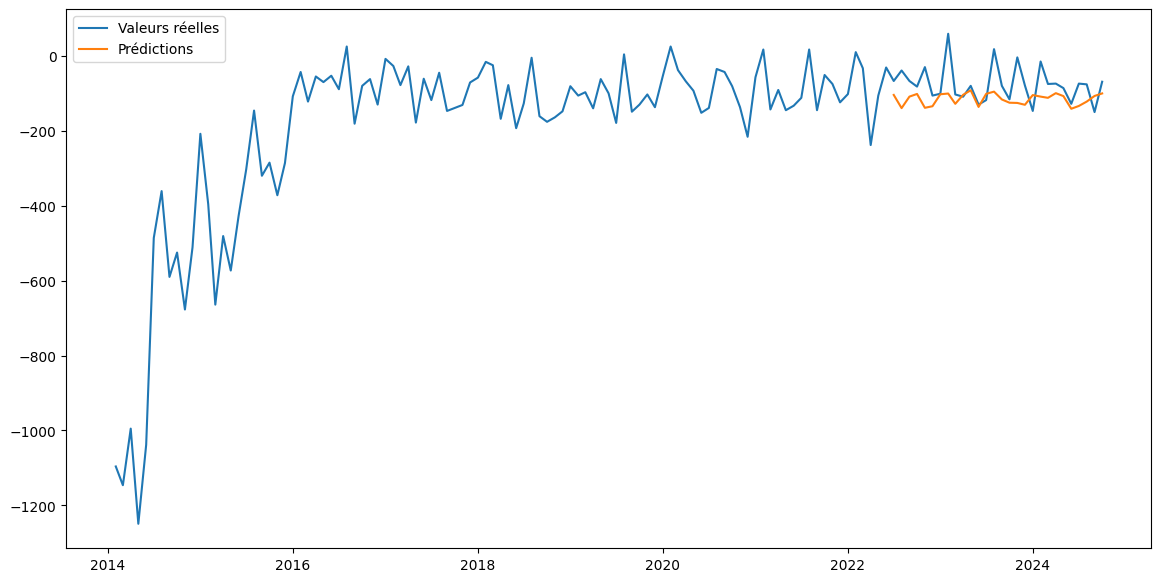

In [16]:
test = data[data['pays'] == pays].sort_values(by='date')

plt.figure(figsize=(14, 7))
plt.plot(test['date'], test['entree_mensuelle'], label='Valeurs réelles')
plt.plot(test['date'].iloc[-len(y_test):], predicted_values, label='Prédictions')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

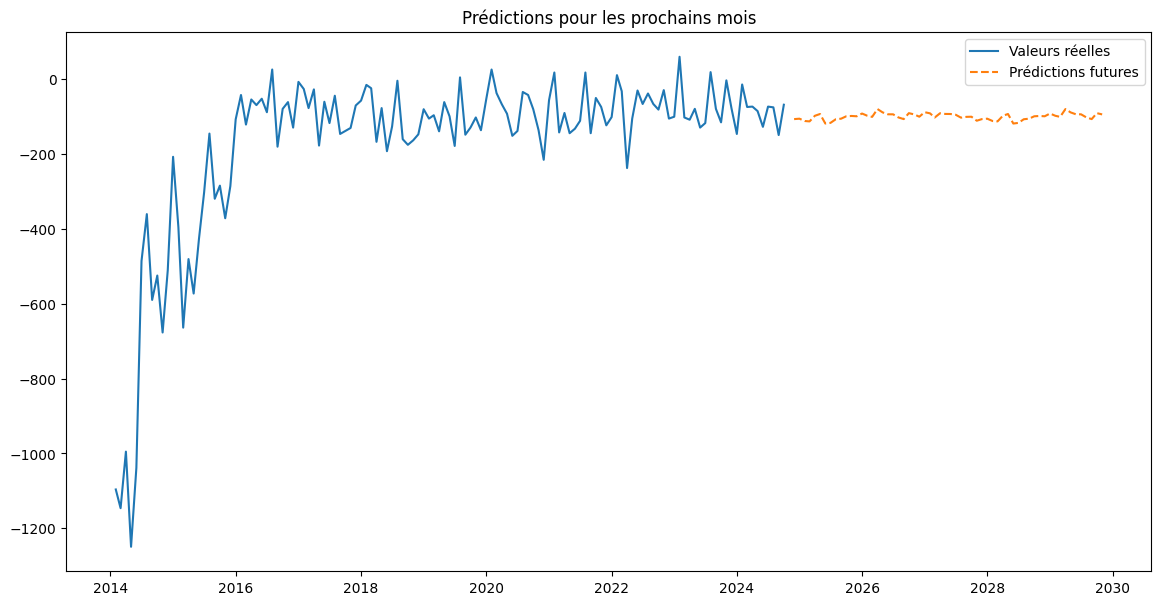

In [17]:
# Nombre de mois à prédire
n_months_to_predict = 12*5

# Dernière séquence des données d'entraînement
last_sequence = normalized_values[-sequence_length:].reshape(1, sequence_length, 1)

# Liste pour stocker les prédictions
future_predictions = []

for _ in range(n_months_to_predict):
    # Prédire le prochain mois
    next_value = model.predict(last_sequence)
    
    # Ajouter la prédiction à la liste
    future_predictions.append(next_value[0, 0])
    
    # Mettre à jour la séquence
    last_sequence = np.roll(last_sequence, -1, axis=1)

# Inverser la normalisation des prédictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Créer une plage de dates pour les prédictions futures
last_date = germany_data['date'].max()
future_dates = pd.date_range(start=last_date, periods=n_months_to_predict + 1, freq='ME')[1:]

# Visualiser les prédictions futures
plt.figure(figsize=(14, 7))
plt.plot(germany_data['date'], germany_data['entree_mensuelle'], label='Valeurs réelles')
plt.plot(future_dates, future_predictions, label='Prédictions futures', linestyle='--')
plt.legend()
plt.title('Prédictions pour les prochains mois')
plt.show()